In [1]:
import torch
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import argparse
import os
from torch import nn
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

Hiper-parámetros a definir por el usuario:

In [1]:
arch = 'vgg13' #Opciones: resnet34, vgg13, alexnet, mobilenet_v2, squeezenet1_1
dataset = 'Imagenette' #Nombre del dataset
val_path = 'Imagenette/val' #Path con las imágenes de validación
batch_size = 128
#Path del modelo preentrenado con SimSiam
pretrained_path = 'simsiam/Unsupervised_Training_Checkpoints/Imagenette/VGG13/checkpoint_800.pth'

Código

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def gen_features(model, dataloader):
    model.eval()
    targets_list = []
    outputs_list = []
    with torch.no_grad():
        for _, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.cuda(0, non_blocking=True)
            targets = targets.cuda(0, non_blocking=True)
            targets_np = targets.data.cpu().numpy()

            outputs = model(inputs)
            outputs_np = outputs.data.cpu().numpy()
            
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)
    return targets, outputs

In [5]:
def tsne_plot(targets, outputs):
    print('generating t-SNE plot...')
    tsne = TSNE(random_state=0)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    df['targets'] = targets

    plt.rcParams['figure.figsize'] = 10, 10
    sns.scatterplot(
        x='x', y='y',
        hue='targets',
        palette=sns.color_palette("hls", 10),
        data=df,
        marker='o',
        legend="full",
        alpha=0.5
    )

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    print('done!')
    return plt

In [6]:
transform_val = transforms.Compose(
    [transforms.Resize((256,256)),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_set = datasets.ImageFolder(val_path, transform=transform_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
# cargamos el modelo autosupervisado preentrenado
checkpoint = torch.load(pretrained_path, map_location="cpu")
model = checkpoint.encoder
torch.cuda.set_device(0)
model = model.cuda(0)
cudnn.benchmark = True

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): 

generating t-SNE plot...


C:\Users\franc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


done!


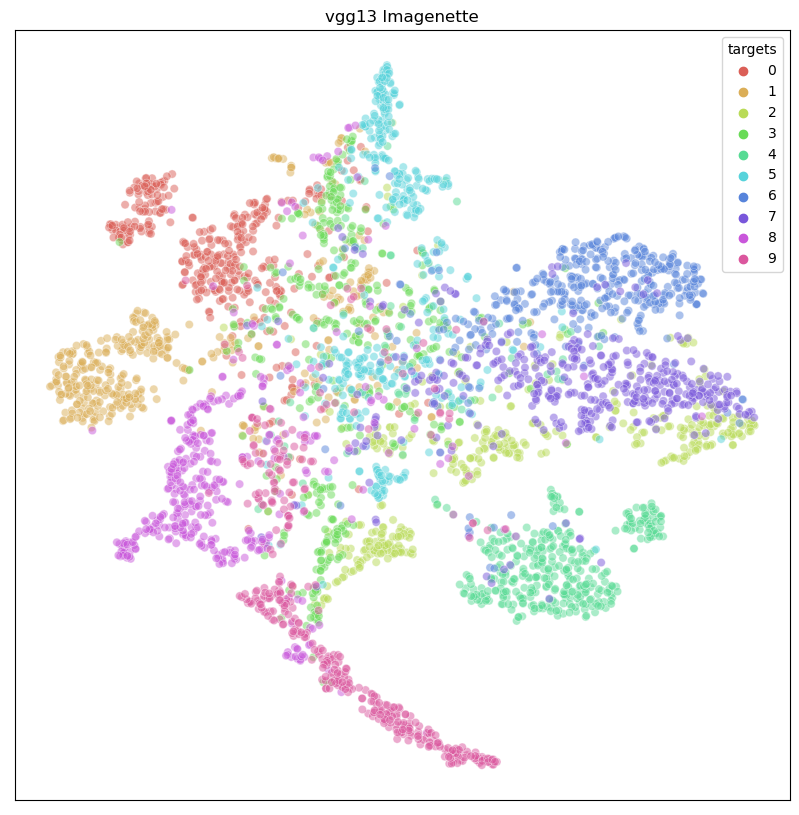

In [8]:
targets, outputs = gen_features(model, val_loader)
plt = tsne_plot(targets, outputs)
plt.title(arch + " " + dataset)
plt.show()